===== STRATEGY PERFORMANCE =====
Start Equity:    $10,000.00
End Equity:      $16,541.60
Total Return:    65.42%
Benchmark B&H:   $17,640.95 (76.41%)
------------------------------
Trades:          819
Win Rate:        37.61%
Profit Factor:   1.21
------------------------------
Max Drawdown:    -8.72%
Sharpe Ratio:    0.71 (Rf=5%)


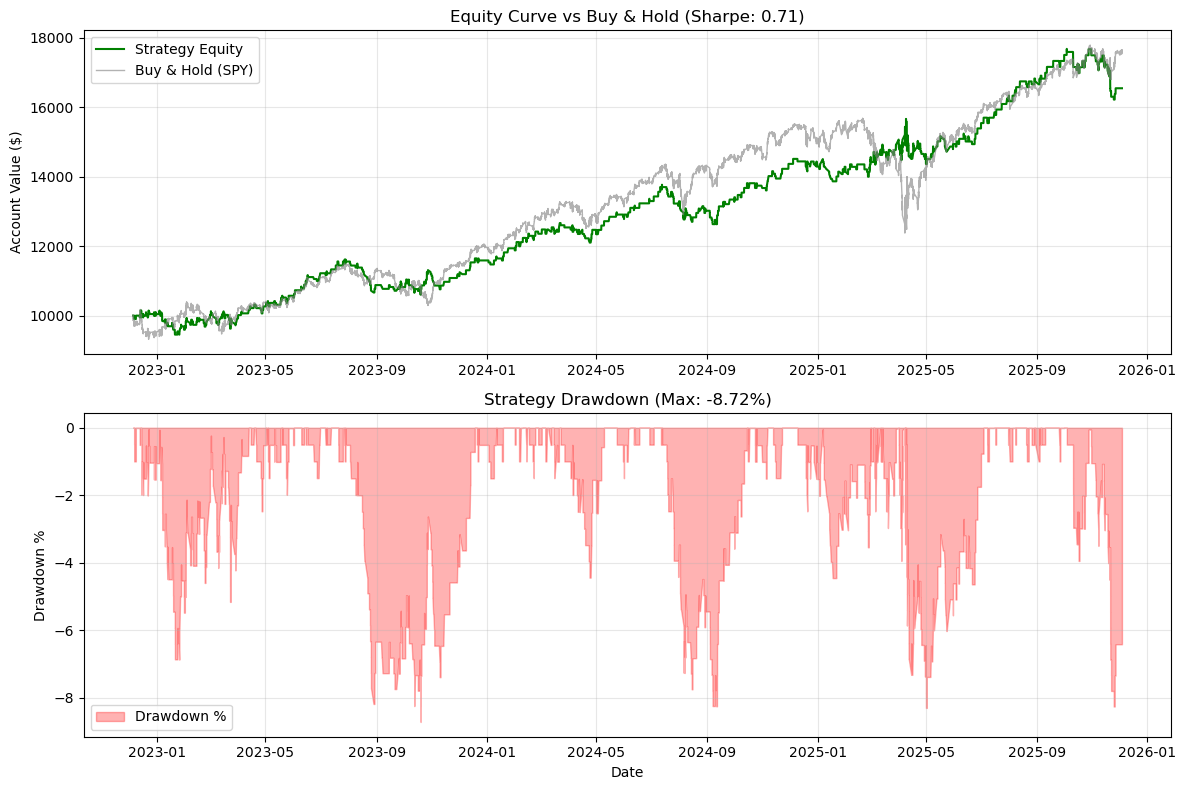

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import time 

df = pd.read_parquet("SPY_1min_3y.parquet")
symbol = "SPY"

df = df.reset_index()
df = df[df["symbol"] == symbol].drop(columns=["symbol"])

df = df.rename(columns={
        "timestamp": "Date",
        "open": "Open",
        "high": "High",
        "low": "Low",
        "close": "Close",
        "volume": "Volume",
        "vwap":"VWAP"
    })

df['Date'] = pd.to_datetime(df['Date']) 
df.set_index("Date", inplace=True)

df['returns'] = df['Close'].pct_change().fillna(0)

df['delta'] = np.where(
    df['Close'] > df['Open'], df['Volume'],
    np.where(df['Close'] < df['Open'], -df['Volume'], 0)
)
df['CVD'] = df.groupby(df.index.date)['delta'].cumsum()

df['CVD_sm'] = df.groupby(df.index.date)['CVD'].transform(lambda x: x.ewm(span=50, adjust=False).mean())
df['cvd_mom'] = df.groupby(df.index.date)['CVD_sm'].diff().fillna(0)
df['cvd_mean'] = df['cvd_mom'].rolling(5).mean()

def add_daily_ema_regime(df, ema_period=100):
    daily = df['Close'].resample('1D').last().ffill()
    ema = daily.ewm(span=ema_period, adjust=False).mean()
    
    df['daily_close'] = df['Close'].resample('1D').ffill().reindex(df.index, method='ffill')
    df['daily_EMA'] = ema.reindex(df.index, method='ffill')

    df['regime_long'] = df['daily_close'] > df['daily_EMA']
    df['regime_short'] = df['daily_close'] < df['daily_EMA']
    return df

df = add_daily_ema_regime(df, 100)

df['long_signal'] = (
    (df['Close'] > df['VWAP']) &
    (df['cvd_mom'] > df['cvd_mean']) &
    (df['regime_long'])
).astype(int)

df['short_signal'] = (
    (df['Close'] < df['VWAP']) &
    (df['cvd_mom'] < df['cvd_mean']) &
    (df['regime_short'])
).astype(int)

def intrabar_exit(row, sl_price, tp_price, direction):
    o = row['Open']
    h = row['High']
    l = row['Low']
    c = row['Close']


    if direction == "long":
       
        if c > o:
            if l <= sl_price: return sl_price, "SL"
            if h >= tp_price: return tp_price, "TP"
       
        elif c < o:
            if h >= tp_price: return tp_price, "TP"
            if l <= sl_price: return sl_price, "SL"
        
        else:
            if l <= sl_price: return sl_price, "SL"
            if h >= tp_price: return tp_price, "TP"

    
    if direction == "short":
        
        if c > o:
            if h >= sl_price: return sl_price, "SL"
            if l <= tp_price: return tp_price, "TP"
        
        elif c < o:
            if l <= tp_price: return tp_price, "TP"
            if h >= sl_price: return sl_price, "SL"
        
        else:
            if h >= sl_price: return sl_price, "SL"
            if l <= tp_price: return tp_price, "TP"

    return None, None


start_time = time(15, 0)  
end_time = time(19, 59)   
df['valid_time'] = (df.index.time >= start_time) & (df.index.time <= end_time)

initial_equity = 10000
equity = initial_equity
risk_per_trade = 0.01
rr = 2
slippage = 0.0000

pos = None
trades = []


equity_history = [{'Date': df.index[0], 'Equity': equity}]

for i in range(1, len(df)):
    row = df.iloc[i]
    prev = df.iloc[i-1]

    if pos is not None:
        exit_price, exit_reason = intrabar_exit(
            row, 
            pos['sl_price'], 
            pos['tp_price'], 
            pos['direction']
        )

        if exit_price is not None:
            exit_price *= (1 - slippage)
            
            if pos['direction'] == "long":
                trade_ret = (exit_price - pos['entry_price']) / pos['entry_price']
            else:  
                trade_ret = (pos['entry_price'] - exit_price) / pos['entry_price']

            equity *= (1 + trade_ret)
            trades.append(trade_ret)
            
            equity_history.append({'Date': row.name, 'Equity': equity})
            
            pos = None
            continue

    if pos is None and row['valid_time']:
        
        if prev['long_signal'] == 1:
            entry_price = row['Open']
            dollar_risk = equity * risk_per_trade
            sl_price = entry_price * 0.995
            tp_price = entry_price * (1 + 0.005 * rr)
            qty = dollar_risk / abs(entry_price - sl_price)

            pos = {
                "direction": "long",
                "entry_price": entry_price,
                "sl_price": sl_price,
                "tp_price": tp_price,
                "qty": qty
            }

        
        elif prev['short_signal'] == 1:
            entry_price = row['Open']
            dollar_risk = equity * risk_per_trade
            sl_price = entry_price * 1.005
            tp_price = entry_price * (1 - 0.005 * rr)
            qty = dollar_risk / abs(entry_price - sl_price)

            pos = {
                "direction": "short",
                "entry_price": entry_price,
                "sl_price": sl_price,
                "tp_price": tp_price,
                "qty": qty
            }


equity_df = pd.DataFrame(equity_history).set_index("Date")


equity_curve = equity_df.reindex(df.index, method='ffill').fillna(initial_equity)
equity_curve.columns = ['Strategy_Equity']


equity_curve['Rolling_Max'] = equity_curve['Strategy_Equity'].cummax()
equity_curve['Drawdown'] = equity_curve['Strategy_Equity'] / equity_curve['Rolling_Max'] - 1
max_drawdown = equity_curve['Drawdown'].min()


daily_equity = equity_curve['Strategy_Equity'].resample('D').last().ffill()
daily_returns = daily_equity.pct_change().dropna()

risk_free_annual = 0.05

risk_free_daily = (1 + risk_free_annual) ** (1/252) - 1

mean_daily_return = daily_returns.mean()
std_daily_return = daily_returns.std()

if std_daily_return == 0:
    sharpe_ratio = 0
else:
    sharpe_ratio = ((mean_daily_return - risk_free_daily) / std_daily_return) * np.sqrt(252)

df['Buy_Hold_Equity'] = (df['Close'] / df['Close'].iloc[0]) * initial_equity

wins = [t for t in trades if t > 0]
losses = [t for t in trades if t < 0]
win_rate = len(wins) / len(trades) * 100 if trades else 0
pf = (sum(wins) / abs(sum(losses))) if losses else np.inf

print("===== STRATEGY PERFORMANCE =====")
print(f"Start Equity:    ${initial_equity:,.2f}")
print(f"End Equity:      ${equity:,.2f}")
print(f"Total Return:    {((equity/initial_equity)-1)*100:.2f}%")
print(f"Benchmark B&H:   ${df['Buy_Hold_Equity'].iloc[-1]:,.2f} ({((df['Buy_Hold_Equity'].iloc[-1]/initial_equity)-1)*100:.2f}%)")
print("-" * 30)
print(f"Trades:          {len(trades)}")
print(f"Win Rate:        {win_rate:.2f}%")
print(f"Profit Factor:   {pf:.2f}")
print("-" * 30)
print(f"Max Drawdown:    {max_drawdown*100:.2f}%")
print(f"Sharpe Ratio:    {sharpe_ratio:.2f} (Rf=5%)")

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(equity_curve.index, equity_curve['Strategy_Equity'], label='Strategy Equity', color='green', linewidth=1.5)
plt.plot(df.index, df['Buy_Hold_Equity'], label='Buy & Hold (SPY)', color='gray', alpha=0.6, linewidth=1)
plt.title(f'Equity Curve vs Buy & Hold (Sharpe: {sharpe_ratio:.2f})')
plt.ylabel('Account Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.fill_between(equity_curve.index, equity_curve['Drawdown'] * 100, 0, color='red', alpha=0.3, label='Drawdown %')
plt.title(f'Strategy Drawdown (Max: {max_drawdown*100:.2f}%)')
plt.ylabel('Drawdown %')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()